This notebook aims to compare the pipelines obtained following the different imputation strategies on the MIMIC dataset. **This notebook requires `experiment.ipynb` to have been run**

In [28]:
import sys
sys.path.append('../')
from utils import *

In [29]:
# Reopen data
labs = pd.read_csv('data/labs_1_day.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv('data/outcomes_1_day.csv', index_col = 0)
outcomes['Death'] = outcomes.Death < 8 # Define binary outcome of interest

In [30]:
# Define group of interest
ethnicity = outcomes.ETHNICITY.str.contains('BLACK').replace({True: 'Black', False: 'Non Black'}) 
ethnicity_unique = ['Black', 'Non Black']

gender = (outcomes.GENDER == 'M').replace({True: 'Male', False: 'Female'})
gender_unique = ['Female', 'Male']

insurance = (outcomes.INSURANCE == 'Private').replace({True: 'Private', False: 'Public'})
insurance_unique = ['Public', 'Private'] 

In [31]:
# To obtain the venn diagram
(ethnicity + ' + ' + gender + ' + ' + insurance).value_counts()

Non Black + Male + Public       12084
Non Black + Female + Public     10026
Non Black + Male + Private       7235
Non Black + Female + Private     4170
Black + Female + Public          1159
Black + Male + Public             890
Black + Male + Private            383
Black + Female + Private          349
dtype: int64

In [32]:
results = 'results/'
threshold = 0.5

# Open results

In [33]:
import os

In [34]:
names = {
    file: file[file.rindex('classification')+14:file.rindex('.csv')]
    for file in os.listdir('results') if '.csv' in file
}

In [36]:
predictions = {}

for file in names:
    predictions[names[file]] = pd.read_csv(results + file, index_col=0)
    print(file, ' -> ', names[file])

# names_reformat = ['Group MICE Missing',  'Group MICE', 'MICE', 'Median'] # Select methods to comapre
names_reformat = ['Group MICE Missing', 'Group MICE', 'Median Missing', 'MICE Missing', 'Median', 'MICE']
predictions = {name: predictions[name] for name in names_reformat[::-1]}

classificationGroup MICE Missing.csv  ->  Group MICE Missing
classificationGroup MICE.csv  ->  Group MICE
classificationMedian Missing.csv  ->  Median Missing
classificationMICE Missing.csv  ->  MICE Missing
classificationMedian.csv  ->  Median
classificationMICE.csv  ->  MICE


# Performances

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss

Differencesin observed labels between training and testing 

### All metrics

Evaluate all metrics on datasets

In [38]:
def evaluate(y_true, groups, groups_unique, y_pred, iterations = 100, p = threshold):
    """
        Compute boostrapped performances
    """
    fprs, tprs, rocs, brs, screened, screened_fpr, screened_fnr = {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, \
        {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, {b: [] for b in groups_unique}, {b: [] for b in groups_unique}

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    fpr_sort = np.argsort(fpr)
    tpr_sort = np.argsort(tpr)
    threshold_fpr = np.interp(0.9, tpr[tpr_sort], thresholds[tpr_sort])
    threshold_tpr = np.interp(0.1, fpr[fpr_sort], thresholds[fpr_sort])

    # Threshold screening
    threshold_top = pd.Series(y_pred).nlargest(int(len(y_pred) * p), keep = 'all').min()

    for group in groups_unique:
        if group == 'Overall':
            y_pred_group = y_pred
            y_true_group = y_true
        else:
            y_pred_group = y_pred[groups == group]
            y_true_group = y_true[groups == group]

        for i in range(iterations):
            bootstrap = np.random.choice(np.arange(len(y_pred_group)), size = len(y_pred_group), replace = True) 
            y_pred_iteration = y_pred_group[bootstrap]
            y_true_iteration = y_true_group[bootstrap]

            # Standard metrics on the boostrapped sample
            brs[group].append(brier_score_loss(y_true_iteration, y_pred_iteration))
            fpr, tpr, thresholds = roc_curve(y_true_iteration, y_pred_iteration)
            thres_order = np.argsort(thresholds)
            fprs[group].append(np.interp(threshold_fpr, thresholds[thres_order], fpr[thres_order]))
            tprs[group].append(np.interp(threshold_tpr, thresholds[thres_order], tpr[thres_order]))
            rocs[group].append(roc_auc_score(y_true_iteration, y_pred_iteration))

            # Percentage screened-out in bottom 30 %
            selected = y_pred_iteration >= threshold_top
            screened[group].append(np.mean(selected)) # Percentage of patients in this group that are prioritized
            screened_fnr[group].append((y_true_iteration[~selected]).sum() / y_true_iteration.sum()) # Wrongly not prioritized
            screened_fpr[group].append((1 - y_true_iteration[selected]).sum() / (1 - y_true_iteration).sum()) # Wrongly prioritized

    result = {}
    if len(groups_unique) == 2:
        difference = 'Difference {} - {}'.format(groups_unique[0], groups_unique[1])
        result.update({
            (difference, "Brier Score", 'Mean'): np.mean(np.array(brs[groups_unique[0]]) - np.array(brs[groups_unique[1]])),
            (difference, "Brier Score", 'Std'): np.std(np.array(brs[groups_unique[0]]) - np.array(brs[groups_unique[1]])),
            (difference, "AUC ROC", 'Mean'): np.mean(np.array(rocs[groups_unique[0]]) - np.array(rocs[groups_unique[1]])),
            (difference, "AUC ROC", 'Std'): np.std(np.array(rocs[groups_unique[0]]) - np.array(rocs[groups_unique[1]])),

            (difference, "FPR @ 90% TPR", 'Mean'): np.mean(np.array(fprs[groups_unique[0]]) - np.array(fprs[groups_unique[1]])),
            (difference, "FPR @ 90% TPR", 'Std'): np.std(np.array(fprs[groups_unique[0]]) - np.array(fprs[groups_unique[1]])),
            (difference, "TPR @ 10% FPR", 'Mean'): np.mean(np.array(tprs[groups_unique[0]]) - np.array(tprs[groups_unique[1]])),
            (difference, "TPR @ 10% FPR", 'Std'): np.std(np.array(tprs[groups_unique[0]]) - np.array(tprs[groups_unique[1]])),

            (difference, "Prioritized", 'Mean'): np.mean(np.array(screened[groups_unique[0]]) - np.array(screened[groups_unique[1]])),
            (difference, "Prioritized", 'Std'): np.std(np.array(screened[groups_unique[0]]) - np.array(screened[groups_unique[1]])),
            (difference, "Wrongly prioritized (FPR)", 'Mean'): np.mean(np.array(screened_fpr[groups_unique[0]]) - np.array(screened_fpr[groups_unique[1]])),
            (difference, "Wrongly prioritized (FPR)", 'Std'): np.std(np.array(screened_fpr[groups_unique[0]]) - np.array(screened_fpr[groups_unique[1]])),
            (difference, "Wrongly not prioritized (FNR)", 'Mean'): np.mean(np.array(screened_fnr[groups_unique[0]]) - np.array(screened_fnr[groups_unique[1]])),
            (difference, "Wrongly not prioritized (FNR)", 'Std'): np.std(np.array(screened_fnr[groups_unique[0]]) - np.array(screened_fnr[groups_unique[1]])),
        })
    for group in groups_unique:
        result.update({
            (group, "Brier Score", 'Mean'): np.mean(brs[group]),
            (group, "Brier Score", 'Std'): np.std(brs[group]),
            (group, "AUC ROC", 'Mean'): np.mean(rocs[group]),
            (group, "AUC ROC", 'Std'): np.std(rocs[group]),

            (group, "FPR @ 90% TPR", 'Mean'): np.mean(fprs[group]),
            (group, "FPR @ 90% TPR", 'Std'): np.std(fprs[group]),
            (group, "TPR @ 10% FPR", 'Mean'): np.mean(tprs[group]),
            (group, "TPR @ 10% FPR", 'Std'): np.std(tprs[group]),

            (group, "Prioritized", 'Mean'): np.mean(screened[group]),
            (group, "Prioritized", 'Std'): np.std(screened[group]),
            (group, "Wrongly prioritized (FPR)", 'Mean'): np.mean(screened_fpr[group]),
            (group, "Wrongly prioritized (FPR)", 'Std'): np.std(screened_fpr[group]),
            (group, "Wrongly not prioritized (FNR)", 'Mean'): np.mean(screened_fnr[group]),
            (group, "Wrongly not prioritized (FNR)", 'Std'): np.std(screened_fnr[group]),
        })
    return pd.Series(result)

In [39]:
# Compute and display performances per group of model
performances = {}
for groups, groups_unique, group_name in [(gender, gender_unique, 'Sex'), (ethnicity, ethnicity_unique, 'Ethnicity'), (insurance, insurance_unique, 'Insurance'), (outcomes, ['Overall'], 'Overall')]:
    print('-' * 42)
    print('Computing for group: ', group_name)
    perf_group = {}
    for m in predictions:
        print('\t- ', m)
        perf_group[m] = {}

        np.random.seed(42)
        preds = predictions[m]

        test = preds.Use != 'Train' # Use the data that will be used for both   
        test = test[test].index
        
        perf_group[m] = evaluate(outcomes.Death.loc[test].values, groups.loc[test].values, groups_unique, preds.loc[test]['Mean'].values)
    performances[group_name] = pd.concat(perf_group, axis = 1).T

------------------------------------------
Computing for group:  Sex
	-  MICE
	-  Median
	-  MICE Missing
	-  Median Missing
	-  Group MICE
	-  Group MICE Missing
------------------------------------------
Computing for group:  Ethnicity
	-  MICE
	-  Median
	-  MICE Missing
	-  Median Missing
	-  Group MICE
	-  Group MICE Missing
------------------------------------------
Computing for group:  Insurance
	-  MICE
	-  Median
	-  MICE Missing
	-  Median Missing
	-  Group MICE
	-  Group MICE Missing
------------------------------------------
Computing for group:  Overall
	-  MICE
	-  Median
	-  MICE Missing
	-  Median Missing
	-  Group MICE
	-  Group MICE Missing


### Display performance

In [40]:
metric = "Prioritized" #'Prioritized', 'AUC ROC', 'Wrongly not prioritized (FNR)'

In [41]:
for groups, groups_unique, group_name in [(gender, gender_unique, 'Sex'), (ethnicity, ethnicity_unique, 'Ethnicity'), (insurance, insurance_unique, 'Insurance'), (outcomes, ['Overall'], 'Overall')]:
    perf_group = performances[group_name][groups_unique]
    perf_group = perf_group.loc[:, perf_group.columns.get_level_values(1) == metric].droplevel(1, 1)
    perf_group = pd.DataFrame.from_dict({model: ["{:.3f} ({:.3f})".format(perf_group.loc[model].loc[i].Mean, perf_group.loc[model].loc[i].Std) for i in perf_group.loc[model].index.get_level_values(0).unique()] for model in perf_group.index}, columns = perf_group.columns.get_level_values(0).unique(), orient = 'index')
    print(perf_group.T.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &           MICE &         Median &   MICE Missing & Median Missing &     Group MICE & Group MICE Missing \\
\midrule
Female &  0.527 (0.008) &  0.538 (0.007) &  0.538 (0.007) &  0.538 (0.007) &  0.525 (0.009) &      0.530 (0.007) \\
Male   &  0.480 (0.007) &  0.471 (0.007) &  0.471 (0.006) &  0.471 (0.006) &  0.481 (0.007) &      0.478 (0.007) \\
\bottomrule
\end{tabular}

\begin{tabular}{lllllll}
\toprule
{} &           MICE &         Median &   MICE Missing & Median Missing &     Group MICE & Group MICE Missing \\
\midrule
Black     &  0.528 (0.017) &  0.530 (0.017) &  0.515 (0.017) &  0.537 (0.018) &  0.293 (0.017) &      0.337 (0.015) \\
Non Black &  0.498 (0.005) &  0.497 (0.005) &  0.498 (0.005) &  0.496 (0.005) &  0.517 (0.005) &      0.513 (0.005) \\
\bottomrule
\end{tabular}

\begin{tabular}{lllllll}
\toprule
{} &           MICE &         Median &   MICE Missing & Median Missing &     Group MICE & Group MICE Missing \\
\midrule
Public  &  

#### Difference in FNR

In [42]:
comparison = {}
for model in performances['Overall'].index:
    comparison[model] = pd.concat({
        'Insurance': performances['Insurance'].loc[model]['Difference Public - Private'][metric],
        'Sex': performances['Sex'].loc[model]['Difference Female - Male'][metric],
        'Ethnicty': performances['Ethnicity'].loc[model]['Difference Black - Non Black'][metric],
    }, axis = 1).T

In [43]:
metrics_short = {
    "Brier Score": "Brier",
    "AUC ROC": "AUC",
    "FPR @ 90% TPR": "False Positive Rate",
    "TPR @ 10% FPR": "True Positive Rate",
    "Prioritized": "Prioritisation",
    "Wrongly prioritized (FPR)": "False Positive Rate",
    "Wrongly not prioritized (FNR)": "False Negative Rate"
}

In [44]:
pd.concat(comparison, axis = 1)

MICE              Median           MICE Missing            \
               Mean       Std      Mean       Std         Mean       Std   
Insurance  0.153396  0.009511  0.185107  0.009138     0.143879  0.008389   
Sex        0.046899  0.009981  0.067019  0.008765     0.067066  0.008034   
Ethnicty   0.030144  0.018250  0.033124  0.017856     0.016991  0.018155   

          Median Missing           Group MICE           Group MICE Missing  \
                    Mean       Std       Mean       Std               Mean   
Insurance       0.157225  0.008334   0.185889  0.009174           0.152248   
Sex             0.066343  0.008732   0.044170  0.010484           0.052000   
Ethnicty        0.040911  0.019829  -0.224286  0.017188          -0.176008   

                     
                Std  
Insurance  0.008333  
Sex        0.008871  
Ethnicty   0.015725

In [45]:
comparison = pd.concat(comparison, axis = 1).swaplevel(0, axis = 1)

In [46]:
comparison

,Mean,Std,Mean,Std,Mean,Std,Mean,Std,Mean,Std,Mean,Std
,MICE,MICE,Median,Median,MICE Missing,MICE Missing,Median Missing,Median Missing,Group MICE,Group MICE,Group MICE Missing,Group MICE Missing
Insurance,0.153396,0.009511,0.185107,0.009138,0.143879,0.008389,0.157225,0.008334,0.185889,0.009174,0.152248,0.008333
Sex,0.046899,0.009981,0.067019,0.008765,0.067066,0.008034,0.066343,0.008732,0.044170,0.010484,0.052000,0.008871
Ethnicty,0.030144,0.018250,0.033124,0.017856,0.016991,0.018155,0.040911,0.019829,-0.224286,0.017188,-0.176008,0.015725


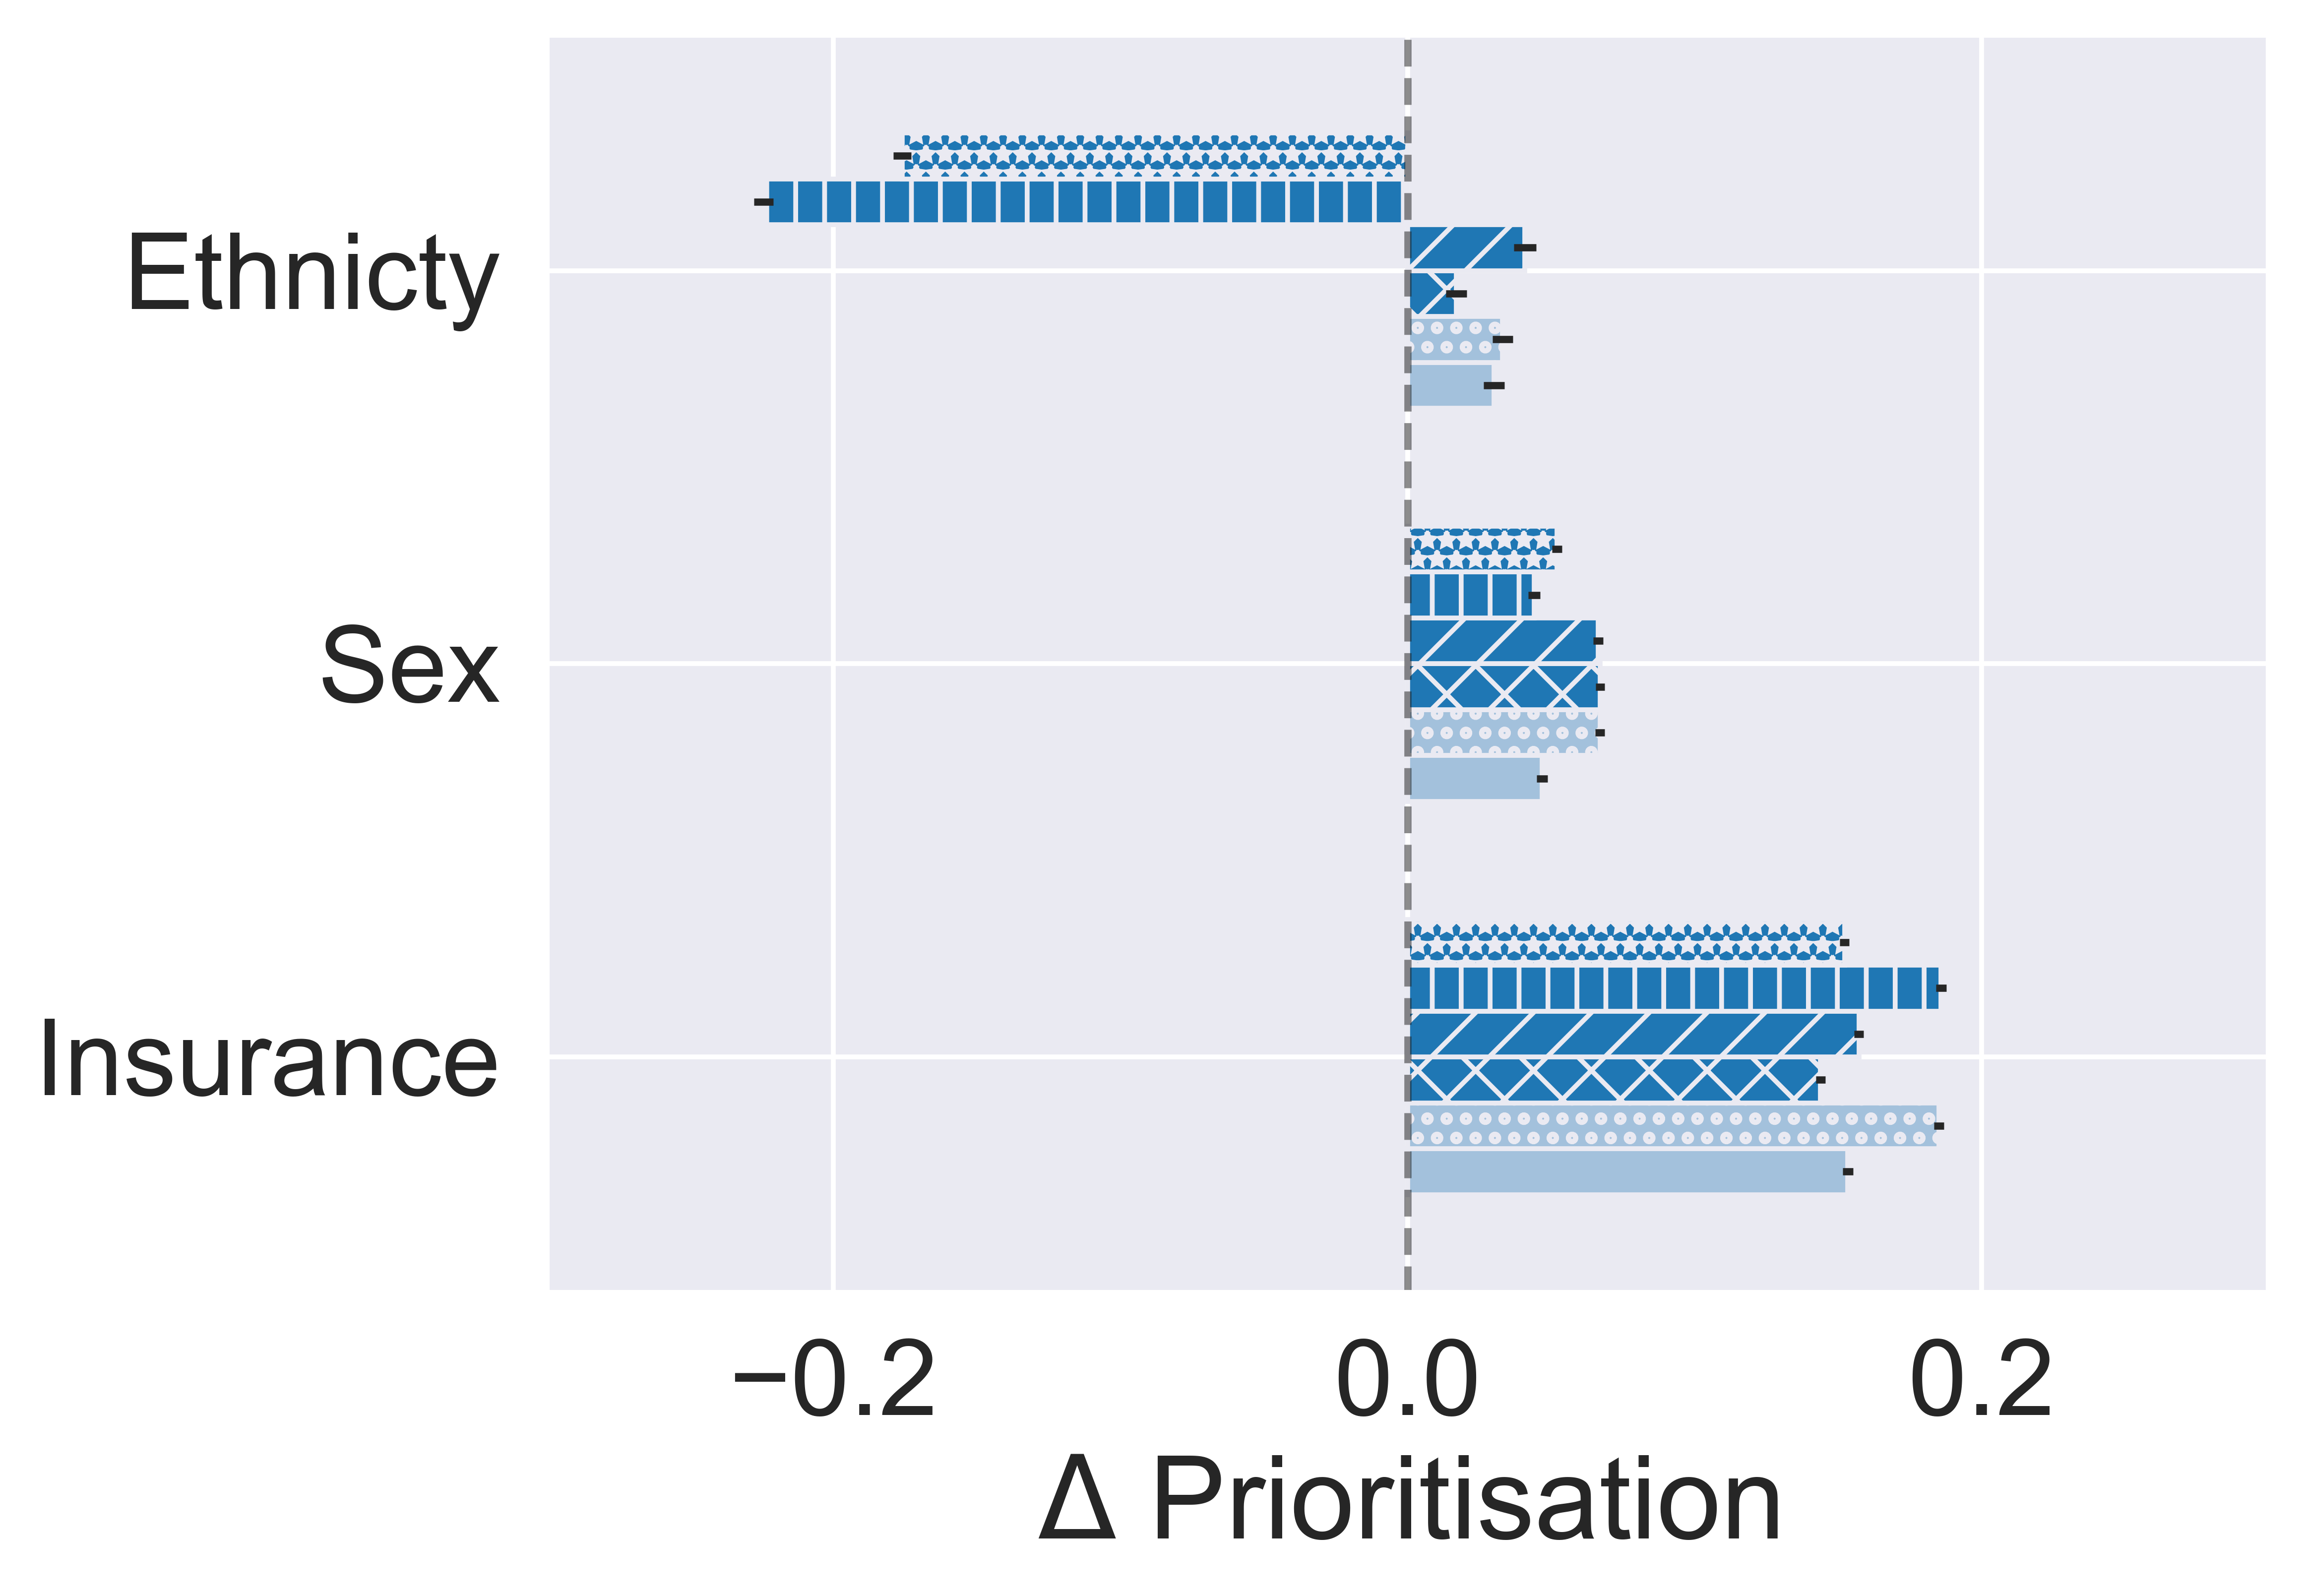

In [54]:
ax = comparison.Mean.plot.barh(xerr=1.96 * comparison.Std / np.sqrt(100), width=0.7, legend='FNR' in metric, figsize=(6.4, 4.8))
hatches = ['', 'ooo', 'xx', '//', '||', '***', '++']
for i, thisbar in enumerate(ax.patches):
    c = list(plt_colors.to_rgba('tab:blue'))
    c[3] = 0.35 if i // len(comparison) < 2 else 1
    thisbar.set(edgecolor='#eaeaf2', facecolor=c, linewidth=1, hatch=hatches[i // len(comparison)])

if 'FNR' in metric:
    patches = [ax.patches[i * len(comparison)] for i in range(len(comparison.Mean.columns))][::-1]
    labels = comparison.Mean.columns.tolist()[::-1]
    ax.legend(patches, labels, loc='upper left', bbox_to_anchor=(1.15, 1.04),
              title='Imputation strategies', handletextpad=0.5, handlelength=1.0, columnspacing=-0.5,)
    for i, label in enumerate(labels):
        ax.text(-0.35, i, label, ha='right', va='center', fontsize=12)
    ax.set_yticklabels([])
plt.xlim(-0.30, 0.30)
plt.axvline(0, ls='--', alpha=0.5, c='k')
plt.xlabel('$\Delta$ {}'.format(metrics_short[metric]))
plt.show()

In [48]:
print(pd.DataFrame.from_dict({group: ["{:.3f} ({:.3f})".format(comparison.loc[group].loc[('Mean', i)], comparison.loc[group].loc[('Std', i)]) for i in comparison.loc[group].index.get_level_values(1).unique()] for group in comparison.index}, columns = comparison.columns.get_level_values(1).unique(), orient = 'index').to_latex())

\begin{tabular}{lllllll}
\toprule
{} &           MICE &         Median &   MICE Missing & Median Missing &      Group MICE & Group MICE Missing \\
\midrule
Insurance &  0.153 (0.010) &  0.185 (0.009) &  0.144 (0.008) &  0.157 (0.008) &   0.186 (0.009) &      0.152 (0.008) \\
Sex       &  0.047 (0.010) &  0.067 (0.009) &  0.067 (0.008) &  0.066 (0.009) &   0.044 (0.010) &      0.052 (0.009) \\
Ethnicty  &  0.030 (0.018) &  0.033 (0.018) &  0.017 (0.018) &  0.041 (0.020) &  -0.224 (0.017) &     -0.176 (0.016) \\
\bottomrule
\end{tabular}

